# Example: simple polynomial regression

This illustrates how I want to use the inversion package on the simplest linear example.

In [1]:
%matplotlib inline
from __future__ import print_function, division
from future.builtins import super, range
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from fatiando import utils
import cPickle as pickle
from inversion import LinearModel, Newton, Damping

In [68]:
class Regression(LinearModel):
    def __init__(self, degree):
        super().__init__(nparams=(degree + 1))
        self.degree = degree
        
    def predict(self, x):
        return sum(self.p_[i]*(x**i) for i in range(self.nparams))
        
    def jacobian(self, x):
        A = np.empty((x.size, self.nparams))
        for i in range(self.nparams):
            A[:, i] = x**i
        return A
    
    def fit(self, x, y, **kwargs):
        super().fit(data=y, args=[x], **kwargs)
        return self
    
    @property
    def polynomial_(self):
        eq = ' + '.join(['{:g}x**{}'.format(self.p_[i], i) 
                         for i in range(self.nparams)])
        return eq

# Test on data

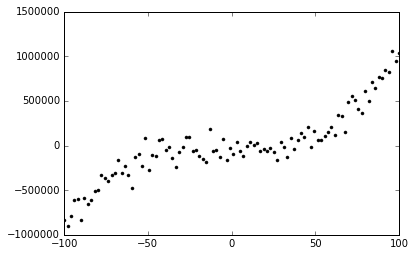

In [69]:
coefs = a, b, c, d = 1000, 10, 0, 1
n = 100
x = np.linspace(-100, 100, n)
y = a + b*x + c*x**2 + d*x**3
yo = utils.contaminate(y, 0.1, percent=True, seed=0)
plt.plot(x, yo, '.k')

[ -4.31267826e+04  -1.87119642e+02   1.29758955e+01   1.00786859e+00]
-43126.8x**0 + -187.12x**1 + 12.9759x**2 + 1.00787x**3


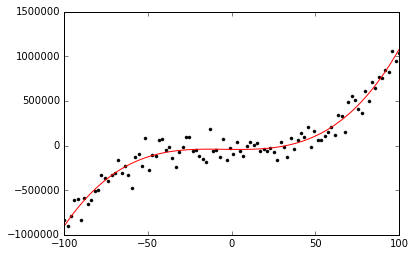

In [70]:
reg = Regression(3)
print(reg.fit(x, yo).p_)
print(reg.polynomial_)

plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

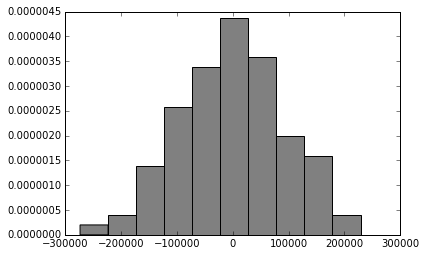

In [71]:
_ = plt.hist(yo - reg.predict(x), 10, normed=True, color='grey')

Can be pickled for use in parallel

In [72]:
reg = pickle.loads(pickle.dumps(reg))

`config` still works but different.

-43126.8x**0 + -187.12x**1 + 12.9759x**2 + 1.00787x**3


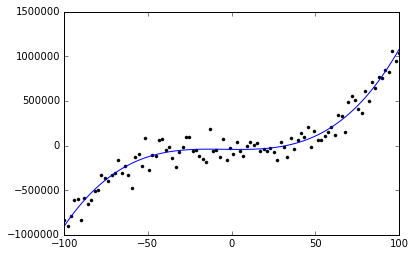

In [73]:
reg = Regression(3).config(optimizer=Newton(initial=np.ones(len(coefs))))
print(reg.fit(x, yo).polynomial_)

plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-')

# Cross-validation

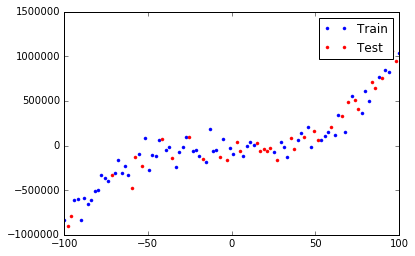

In [105]:
rand = np.random.RandomState(42)
whole = rand.permutation(x.size)
divide = int(0.65*x.size)
train, test = whole[:divide], whole[divide:]

plt.plot(x[train], yo[train], '.b', label='Train')
plt.plot(x[test], yo[test], '.r', label='Test')
plt.legend()

Best degree: 3


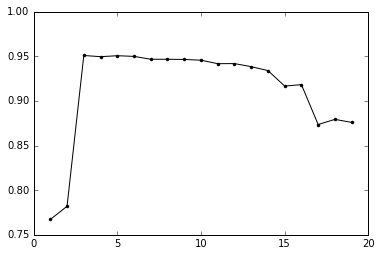

In [106]:
degrees = list(range(1, 20))
scores = [Regression(i).fit(x[train], yo[train]).score(x[test], yo[test])
          for i in degrees]

best = degrees[np.argmax(scores)]

print('Best degree:', best)
plt.plot(degrees, scores, '.-k')

-43126.8x**0 + -187.12x**1 + 12.9759x**2 + 1.00787x**3


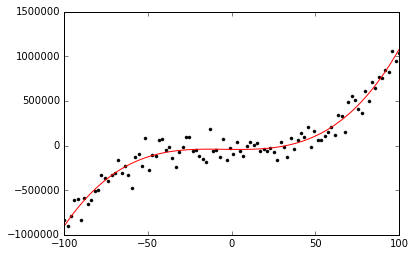

In [107]:
reg = Regression(best).fit(x, yo)
print(reg.polynomial_)

plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

# Scikit-learn cross-validation

In [96]:
from sklearn.cross_validation import KFold

Best degree: 3


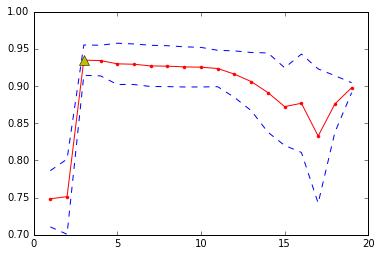

In [121]:
degrees = list(range(1, 20))
score_means = []
score_stds = []
kfold = KFold(yo.size, n_folds=3, shuffle=True, random_state=np.random.RandomState(42))
for degree in degrees:
    scores = [Regression(degree).fit(x[train], yo[train]).score(x[test], yo[test])
              for train, test in kfold]
    score_means.append(np.mean(scores))
    score_stds.append(np.std(scores))
    
best = np.argmax(score_means)
degree = degrees[best]
print('Best degree:', degree)

plt.plot(degrees, score_means, '.-r')
plt.plot(degrees[best], score_means[best], '^y', markersize=10)
plt.plot(degrees, np.array(score_means) + np.array(score_stds), '--b')
plt.plot(degrees, np.array(score_means) - np.array(score_stds), '--b')

# Re-weighted

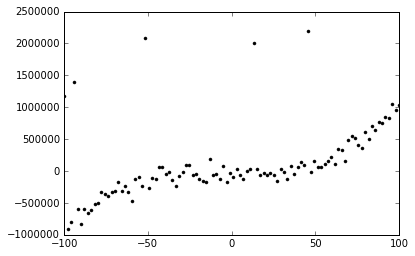

In [77]:
rand = np.random.RandomState(3)
yo2 = np.copy(yo)
yo2[rand.choice(yo.size, size=5)] += 2e6

plt.plot(x, yo2, '.k')

7503.47x**0 + 2378.45x**1 + 27.4935x**2 + 0.409119x**3


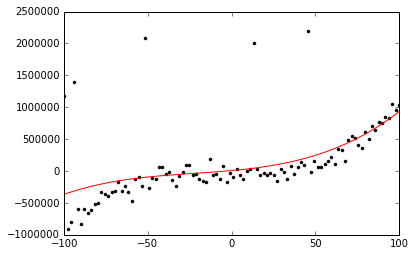

In [78]:
reg = Regression(3).fit(x, yo2)
print(reg.polynomial_)

plt.plot(x, yo2, '.k')
plt.plot(x, reg.predict(x), '-r')

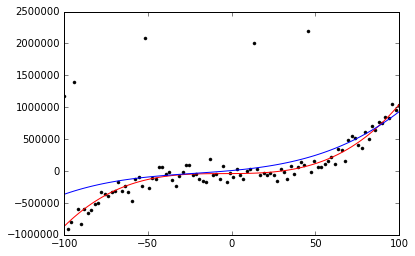

In [79]:
reg2 = Regression(3).fit_reweighted(x, yo2)

plt.plot(x, yo2, '.k')
plt.plot(x, reg2.predict(x), '-r')
plt.plot(x, reg.predict(x), '-b')

## Regularization

In [138]:
class Ridge(Regression):
    def __init__(self, degree, damping=1e-5, scale=1):
        super().__init__(degree)
        assert damping > 0
        regul = [[damping/self.nparams, Damping(self.nparams)]]
        self.config(regularization=regul, scale=scale)

Best mu: 1.7433288222e+25


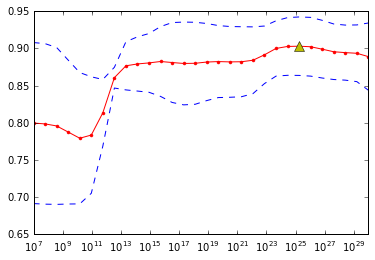

In [170]:
mus = np.logspace(7, 30, 30)
degree = 20
A = Ridge(degree).jacobian(x)

score_means = []
score_stds = []
kfold = KFold(yo.size, n_folds=3, shuffle=True, random_state=np.random.RandomState(42))
for mu in mus:
    scores = [Ridge(degree, damping=mu).fit(x[train], yo[train]).score(x[test], yo[test])
              for train, test in kfold]
    score_means.append(np.mean(scores))
    score_stds.append(np.std(scores))
    
best = np.argmax(score_means)
mu = mus[best]
print('Best mu:', mu)

plt.plot(mus, score_means, '.-r')
plt.plot(mus[best], score_means[best], '^y', markersize=10)
plt.plot(mus, np.array(score_means) + np.array(score_stds), '--b')
plt.plot(mus, np.array(score_means) - np.array(score_stds), '--b')
plt.xscale('log')

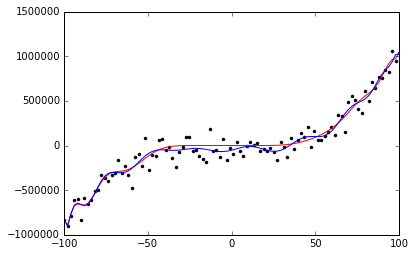

In [171]:
ridge = Ridge(damping=mu, degree=degree).fit(x, yo)
reg = Regression(degree).fit(x, yo)

plt.plot(x, yo, '.k')
plt.plot(x, ridge.predict(x), '-r')
plt.plot(x, reg.predict(x), '-b')